In [1]:
import os
import logging

from typing import List, Dict, Optional
from collections import namedtuple, Counter, defaultdict

import lxml.etree as ET
from pandas import DataFrame
import numpy as np
from sklearn.decomposition import PCA, FactorAnalysis as FA

import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('seaborn')

## Setup the lemmas that are interesting to search for

In [2]:
import glob
lemmas = []
for text in glob.glob("/home/thibault/dev/corpus-builder/output/*.xml"):
    xml = ET.parse(text)
    lemmas.extend([
        y[:y.find("(")]
        for x in xml.xpath("//w[@ana]/@lemma") 
        for y in x.split("|")
        if y
    ])
lemmas = sorted(list(set(lemmas)))

GLOBAL_WINDOW = 10
MIN_FREQ = 10
COOC_MIN_FREQ = 10
NORMALIZATION: str = "ratio-log"
IGNORE_WORDS = ("sum1", "que", "habeo", "dico2", "facio", "possum1", "do", "uideo", "uolo3", "iam", "sic",
               "tamen", "tam", "puto", "res")
TEXTS = ["urn:cts:latinLit:phi1294.phi002.perseus-lat2", "urn:cts:latinLit:phi1103.phi001.lascivaroma-lat1"]
WINDOWS = {
    "urn:cts:latinLit:phi1294.phi002.perseus-lat2": 2,  # Stop at the second element of citation
    "urn:cts:latinLit:phi1103.phi001.lascivaroma-lat1": 1
}
POS = [
    "ADJadv.mul", "ADJadv.ord", "ADJcar", "ADJdis", "ADJmul", "ADJord", 
    #"ADJqua", 
    "ADV", "ADVint", "ADVint", "ADVneg", "ADVrel", 
    "CONcoo", "CONsub", "INJ",
    "NOMcom", "NOMpro", 
    "OUT", "PRE", "PROdem", 
    "PROind", "PROint", "PROper", "PROpos", "PROpos", "PROref", "PROrel", "PUNC", 
    "VER", "VERaux", "FOR"
]
POS = [
    "ADJadv.mul", "ADJadv.ord", "ADJcar", "ADJdis", "ADJmul", "ADJord", 
    #"ADJqua", 
    #"ADV", 
    "ADVint", "ADVint", "ADVneg", "ADVrel", 
    "CON", "CONcoo", "CONsub", "INJ", 
    #"NOMcom", "NOMpro",
    "OUT", "PRE", "PROdem", 
    "PROind", "PROint", "PROper", "PROpos", "PROpos", "PROref", "PROrel", "PUNC", 
    #"VER", 
    "VERaux", "FOR"
]

## Set up the functions

In [3]:
def filter_ref(words, main_word, text=None):
    main = main_word.attrib["n"].split(".")[:WINDOWS[text]]
    return [
        word 
        for word in words
        if word.attrib["n"].split(".")[:WINDOWS[text]] == main
    ]


def get_window(index, words, window, serious_window=False, text=None, filter_pos=None):
    start = max(index-window, 0)
    end = min(index+window+1, len(words)-1)
    out = words[start:index] + words[index+1:end]
    if filter_pos:
        out = [tok for tok in out if tok.attrib["pos"] not in filter_pos]
    if serious_window is False:
        return out
    return filter_ref(out, main_word=words[index], text=text)


def search_words(
    texts: List[str],
    lemma: List[str],
    window: int,
    ignore_pos: Optional[List[str]] = None,
    filter_pos: Optional[List[str]] = None,
    serious_window: bool = False,
    get_general_frequencies: bool = True
):
    """ Retrieve words and cooccurrents
    
    :param texts: Lists of text identifiers that are looked into
    :param ignore_pos: POS to ignore in counting cooccurences (like punct)
    :param filter_pos: POS to count in the window but not as a feature for the cooccurences
    :param lemma: Lemma which are searched
    :param window: Number of words on the left and on the right to keep
    :param serious_window: Keep only cooccurrences in the same document segment.
    
    """
    ignore_pos = ignore_pos or []
    filter_pos = filter_pos or []
    
    out = defaultdict(Counter)
    occs = Counter()
    GenFreq = Counter()
    
    for text in texts:
        xml = ET.parse(f"/home/thibault/dev/latin-lemmatized-texts/lemmatized/xml/{text}.xml")
        words = xml.xpath(
            f"//tei:w[not(contains(\"{'|'.join(ignore_pos)}\", @pos))]",
            namespaces={"tei": "http://www.tei-c.org/ns/1.0"}
        )
        if get_general_frequencies:
            GenFreq.update(
                Counter([
                    w.attrib["lemma"]
                    for w in words
                    if not filter_pos or (filter_pos and w.attrib["pos"] not in filter_pos)
                ])
            )
        for index, word in enumerate(words):
            if word.attrib["lemma"] in lemma:
                if filter_pos and word.attrib["pos"] in filter_pos:
                    continue
                occs[word.attrib["lemma"]] += 1
                data = get_window(
                    index, 
                    words, 
                    window, 
                    serious_window=serious_window,
                    text=text,
                    filter_pos=filter_pos
                )
                out[word.attrib["lemma"]].update(Counter([w.attrib["lemma"] for w in data]))   
    return out, occs, GenFreq

def generate_dataframe(
    lemma_connections: Dict[str, Dict[str, int]],
    lemma_count: Dict[str, int],
    floor: int,
    cooc_floor: int,
    ignore_words: Optional[List[str]] = None
):
    ignore_words = ignore_words or []
    df = DataFrame({
        k:v
        for k, v in lemma_connections.items()
        if len(v) and lemma_count[k] >= floor
    }).transpose()
    
    # Drop items where the number of cooccurrences is too low
    df.drop([
        col
        for col, val in df.sum().iteritems()
        if val < cooc_floor or col in ignore_words# or col in pivots  # Remove pivots as feature ?
    ], axis=1, inplace=True)
    return df

def parse_and_window(
    texts: List[str],
    lemma: List[str],
    window: int,
    serious_window=False,
    floor: int = 5,
    ignore_pos=["PUNC"],
    filter_pos=None,  # Filter OUT
    cooc_floor: int = 3,
    ignore_words=IGNORE_WORDS,
    normalization: Optional[str] = None # binarize, None, ratio, log
) -> (Dict[str, Dict[str, int]], Dict[str, int], Dict[str, int]):
    
    # 1. Retrieve and treat first order words ("pivots")
    out, occs, GenFreq = search_words(
        lemma=lemma,
        texts=texts,
        serious_window=serious_window,
        window=window,
        ignore_pos=ignore_pos,
        filter_pos=filter_pos,
        get_general_frequencies=normalization not in {"binarize", None}
    )
    
    # Warns about data that does not meet a minimal threshold
    for k, v in out.items():
        if len(v) and occs[k] < floor and k in lemma:
            logging.warning(f"{k} [pivot] has been rejected because of its underrepresentation ({occs[k]} occs for a {floor} limit)")
    
    FirstDF = generate_dataframe(
        lemma_connections=out,
        lemma_count=occs,
        floor=floor,
        cooc_floor=cooc_floor,
        ignore_words=ignore_words
    )
    
    pivots = FirstDF.index.tolist()
    second_zone = FirstDF.columns.tolist()

    # 2. Retrieve and treat second order words ("seconds")
    sec_out, sec_occs, _ = search_words(
        lemma=second_zone,
        texts=texts,
        serious_window=serious_window,
        window=window,
        ignore_pos=ignore_pos,
        filter_pos=filter_pos
    )
    out.update(sec_out)
    occs.update(sec_occs)
    
    DF_Pivot = generate_dataframe(
        lemma_connections=out,
        lemma_count=occs,
        floor=floor,
        cooc_floor=cooc_floor,
        ignore_words=ignore_words
    )
    
    if normalization:
        if normalization.startswith("ratio"):
            # Normalisation: quel part des occurences globales des coocurrents représente chacune des occurences rencontrées 
            DF_Pivot = DF_Pivot.divide([GenFreq[col] for col in DF_Pivot.columns])
        if "-log" in normalization:
            DF_Pivot = DF_Pivot.apply(np.log10)
        if normalization == "binarize":
            DF_Pivot = DF_Pivot.fillna(0).apply(lambda x: x != 0)
    
    return DF_Pivot, occs, pivots, second_zone, GenFreq

## Generate adversarial PCA / FA

In [4]:
Analysis = namedtuple("Analysis", ["df", "freq", "pivots", "seconds", "decomp", "transformed"])

def generate_adversarial(
    texts,
    lemma,
    window,
    normalization,
    floor,
    cooc_floor,
    ignore_pos,
    filter_pos
):
    clean_out, clean_occs, clean_pivots, clean_second_zone, GenFreq = parse_and_window(
        texts,
        lemma=lemma,
        window=window,
        serious_window=True,
        normalization=normalization,
        floor=floor,
        cooc_floor=cooc_floor,
        ignore_pos=ignore_pos,
        filter_pos=filter_pos
    )
    print(f"{clean_out.shape} Shape")
    fa_clean = PCA(n_components=clean_out.shape[0])
    fa_clean_transformed = fa_clean.fit_transform(clean_out.fillna(0))
    
    dirty_out, dirty_occs, dirty_pivots, dirty_second_zone, _ = parse_and_window(
        texts,
        lemma=lemma,
        window=window,
        serious_window=False,
        normalization=normalization,
        floor=floor,
        cooc_floor=cooc_floor,
        ignore_pos=ignore_pos,
        filter_pos=filter_pos
    )
    print(f"{dirty_out.shape} Shape")
    fa_dirty = PCA(n_components=dirty_out.shape[0])
    fa_dirty_transformed = fa_dirty.fit_transform(dirty_out.fillna(0))
    
    return (
        Analysis(clean_out, clean_occs, clean_pivots, clean_second_zone, fa_clean, fa_clean_transformed),
        Analysis(dirty_out, dirty_occs, dirty_pivots, dirty_second_zone, fa_dirty, fa_dirty_transformed),
        GenFreq
    )

## Get research lemma

In [5]:
EXCLUDED = "ad2 ipse munus uolo3 facio rumpo uxor ille nos meus uir res porto janua Uenus".split() + list(IGNORE_WORDS)
WORDS = sorted([
    "mentula", "cunnus", "lasciuus", "paedico2", 
    "futuo", "culus", "irrumo", "fello", "fellator",
    "castus", "improbus", "probus",
    "effeminatus"
    #"caco" #, "medium", 
])

EXTEND = False
if EXTEND:
    WORDS.extend(sorted(list(set([
        l 
        for l in lemmas
        if l not in EXCLUDED
    ]))))

## Plot automatique

In [9]:
def plot(clean, dirty, gen_freq, plotly=True, pyplot=True):
    
    vocab = clean.df.index.tolist() + dirty.df.index.tolist()
    milestone = clean.df.shape[0]
    XY = np.concatenate([
        clean.transformed[:,(0,1)],
        dirty.transformed[:,(0,1)]
    ], axis=0)
    
    pyplot_fig = None
    plotly_fig = None
    
    if pyplot:
        plt.figure(figsize=(20,20), dpi=300)
        plt.scatter(
            XY[:,0],
            XY[:,1],
            marker="x",
            color="black",
            s=30,
            linewidths=1,
            label="Crosses"
        )
        plt.xlabel("PC1",size=30)
        plt.ylabel("PC2",size=30)
        plt.title("Espace sémantique (Rouge: Segmenté, Bleu: Continu)",size=20)
        for i, word in enumerate(vocab):
            plt.annotate(
                f"{word} {clean.freq[word] if i < milestone else dirty.freq[word]}",
                xy=(XY[i,0],XY[i,1]),
                color="r" if i < milestone else "b"
            )
        pyplot_fig = plt.gcf()
        
    if plotly:
        merged_df = DataFrame(XY, columns=["pc1", "pc2"], index=vocab)
        merged_df["categorie"] = [
            "Segmenté / Pivot" if word in clean.pivots else "Segmenté / Seconds"
            for word in clean.df.index.tolist()
        ] + [
            "Non-Segmenté / Pivot" if word in dirty.pivots else "Non-Segmenté / Pivots"
            for word in dirty.df.index.tolist()
        ] 

        merged_df["frequency"] = [
            GenFreq[word]
            for word in clean.df.index.tolist()
        ] + [
            GenFreq[word]
            for word in dirty.df.index.tolist()
        ] 

        plotly_fig = px.scatter(
            merged_df,
            x="pc1", y="pc2", 
            color="categorie",
            size="frequency",
            text=merged_df.index,
            color_discrete_sequence=["darkblue", "lightblue", "darkgreen", "lightgreen"],
            labels={
                "pc1": f"PC1 (Segmnenté: {clean.decomp.explained_variance_ratio_[0]*100:.2f}%, " \
                            + f"Non-Segmenté: {dirty.decomp.explained_variance_ratio_[0]*100:.2f}%)",
                "pc2": f"PC2 (Segmnenté: {clean.decomp.explained_variance_ratio_[1]*100:.2f}%, " \
                            + f"Non-Segmenté: {dirty.decomp.explained_variance_ratio_[1]*100:.2f}%)",
                "categorie": "Catégorie",
                "frequency": "Fréquence globale",
            }
        )

        plotly_fig.update_traces(textposition='top center')

        plotly_fig.update_layout(
            height=800,
            title_text='Analyse factorielle des lemmes de la sexualité sur un corpus poétique'
        )

    return plotly_fig, pyplot_fig

## Analysis

### Sexuality

(21, 299) Shape


(30, 650) Shape


<ipython-input-10-555ae5fc594b>:13: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



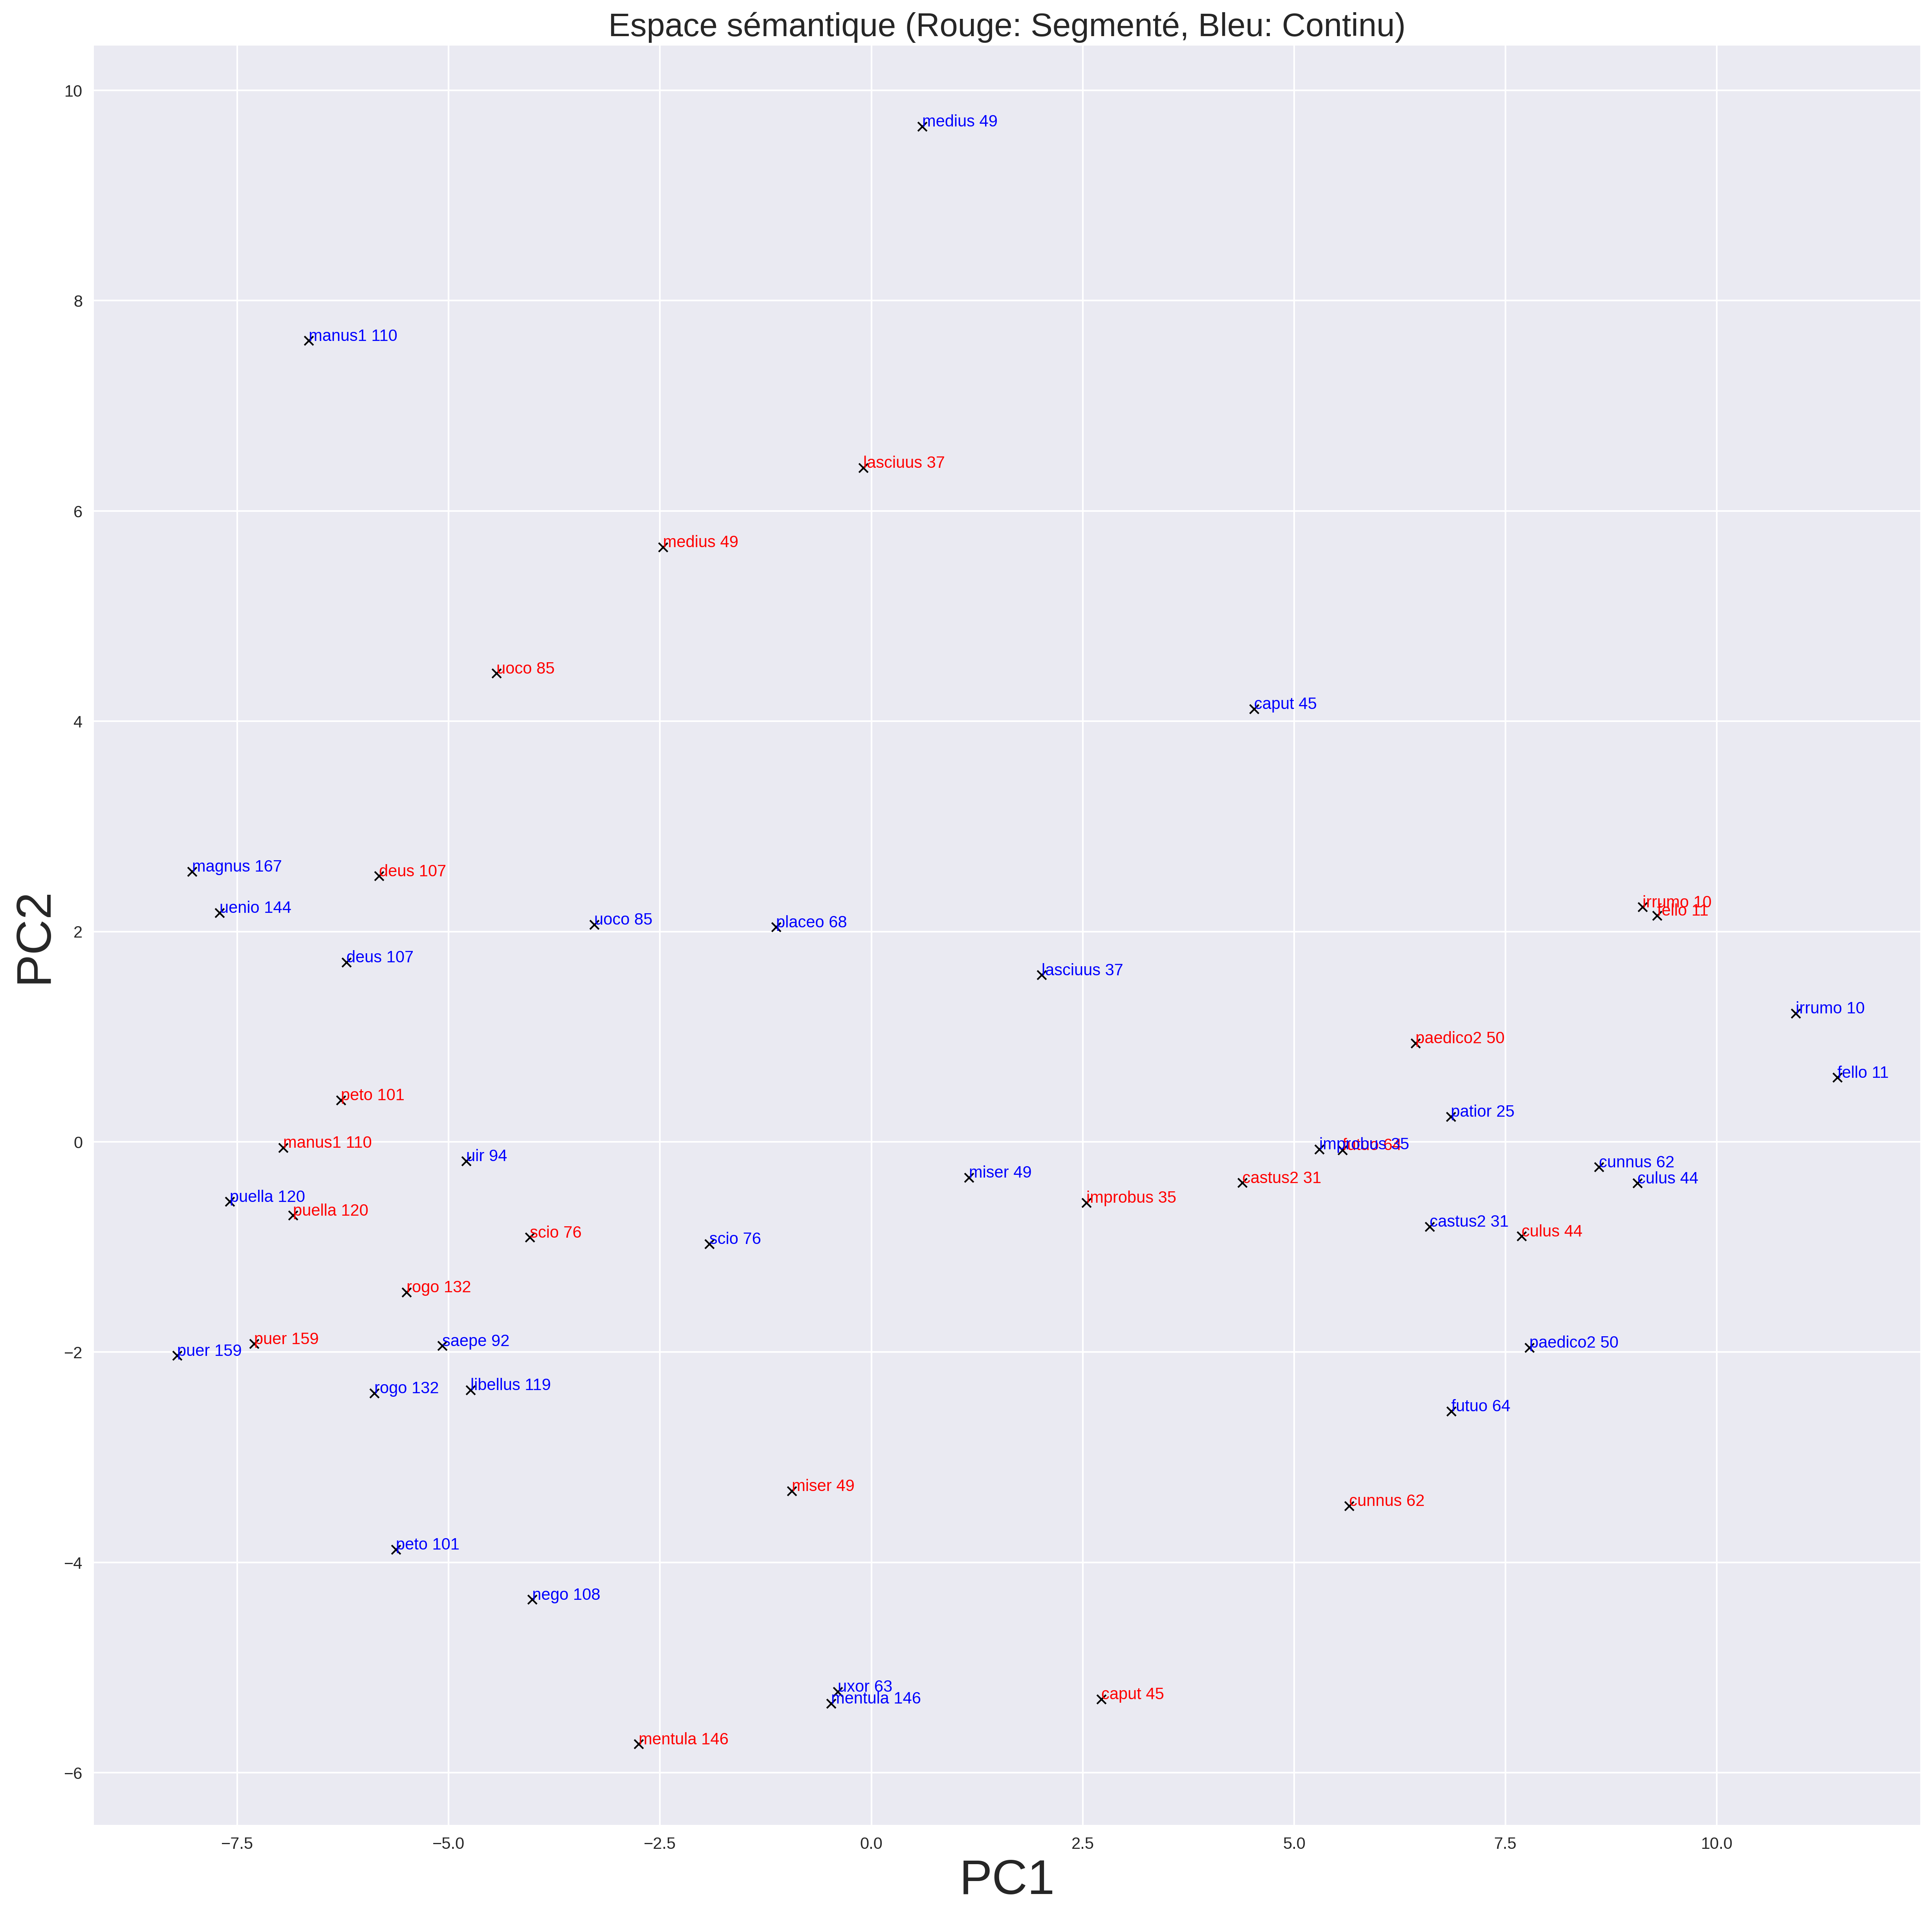

In [10]:
Clean, Dirty, GenFreq = generate_adversarial(
    texts=TEXTS,
    lemma=WORDS,
    window=GLOBAL_WINDOW,
    normalization=NORMALIZATION,
    floor=MIN_FREQ,
    cooc_floor=COOC_MIN_FREQ,
    ignore_pos=["PUNC", "OUT"],
    filter_pos=POS
)
plotly_fig, pyplot_fig = plot(Clean, Dirty, GenFreq, plotly=True, pyplot=True)

pyplot_fig.show()
plotly_fig.show()

#fig.write_html("importance-segmentation.html")
#print(f"file://{os.getcwd()}/importance-segmentation.html")

### Books

(42, 787) Shape


(63, 1278) Shape


<ipython-input-13-dfe1ebd4e926>:13: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



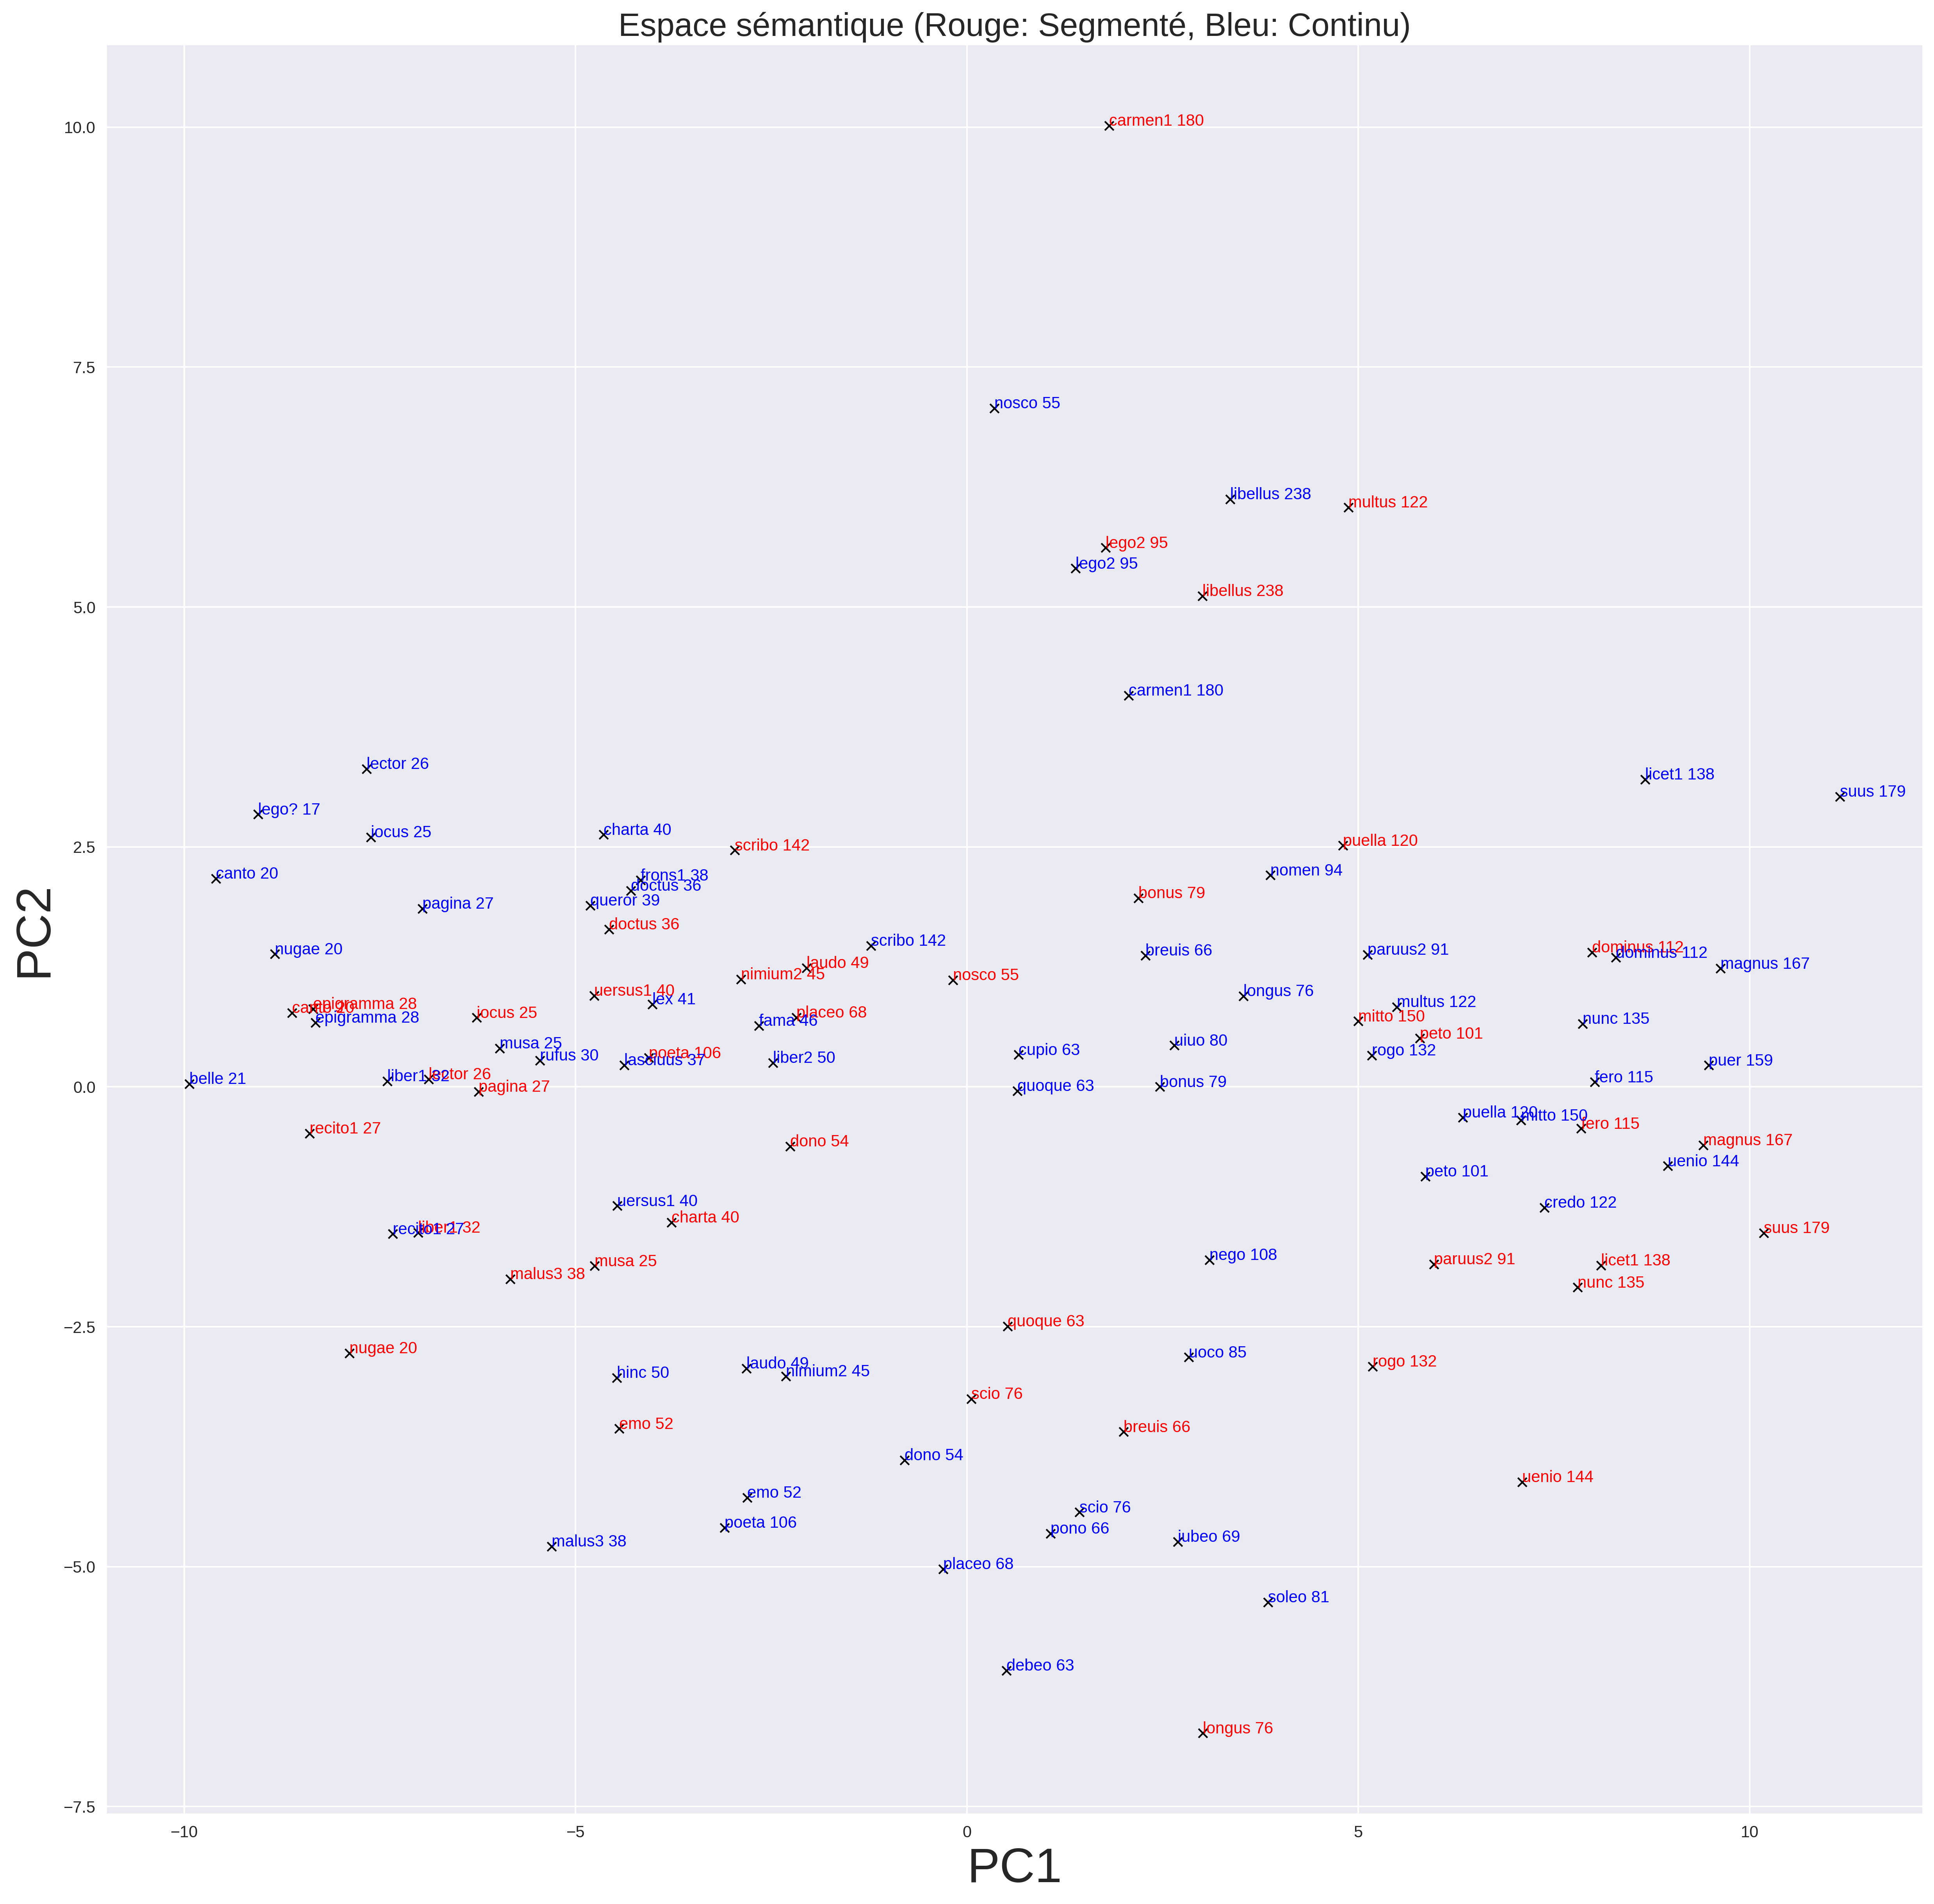

In [13]:
Clean, Dirty, GenFreq = generate_adversarial(
    texts=TEXTS,
    lemma=["carmen1", "lego", "scribo", "libellus", "poeta"],
    window=GLOBAL_WINDOW,
    normalization=NORMALIZATION,
    floor=MIN_FREQ,
    cooc_floor=COOC_MIN_FREQ,
    ignore_pos=["PUNC", "OUT"],
    filter_pos=POS
)
plotly_fig, pyplot_fig = plot(Clean, Dirty, GenFreq, plotly=True, pyplot=True)

pyplot_fig.show()
plotly_fig.show()

#fig.write_html("importance-segmentation.html")
#print(f"file://{os.getcwd()}/importance-segmentation.html")

## Plot

## Playground

In [ ]:
fa_dirty.explained_variance_ratio_
#fa_dirty.noise_variance_